In [1]:
#define _USE_MATH_DEFINES
#include<cmath>
#include<mkl.h>
#include<opencv2/opencv.hpp>
#include<random>
#include<vector>
#include<chrono>

![](https://i.imgur.com/GLVc3Il.png)

In [2]:
float normal_distribution(float x, float mean, float stddev) {
	return (1.f / (stddev*sqrt(2 * M_PI)))*pow(M_E, -pow(x - mean, 2) / (2 * pow(stddev, 2)));
}

In [3]:
void draw_normal_distribution(cv::Mat& img,int range_negative,int range_positive,float mean,float stddev) {
	std::vector<int> dst(img.cols, 0);
	for (int i = 0; i < img.cols; i++) {
		float x = static_cast<float>(i) / img.cols;	//0~1
		x = x * (range_positive - range_negative);	//0~20
		x += range_negative;	//-10~10
		float y = normal_distribution(x,mean,stddev)*img.rows;
		dst[i] = y;
	}
	for (int i = 0; i < dst.size()-1; i++) {
		cv::line(img, cv::Point(i, img.rows-dst[i]), cv::Point(i + 1, img.rows-dst[i + 1]), cv::Scalar(0, 0, 255),2);
	}
}

In [4]:
void draw_normal_distribution_bar(std::vector<float>& values,float mean,float stddev, std::string winname) {
	const int rows = 500;
	const int cols = 1000;
	float range_positive = 10;
	float range_negative = -10;
	std::vector<int> dist(cols, 0);
	std::for_each(values.begin(), values.end(), [&](float& val)->void {
		val -= range_negative;            //0~(maxv-minv)
		val = val / (range_positive - range_negative); //0~1
		val *= (cols-1);
	});
	for (int i = 0; i < values.size(); i++) {
		int idx = static_cast<int>(values[i]);
		if(idx>=0 && idx<cols)
			dist[idx]++;
	}
	float zero_y = normal_distribution(0.f, mean, stddev);
	float mulval = zero_y*rows / dist[dist.size() / 2] ;
	for (int i = 0; i < dist.size(); i++) {
		dist[i] = dist[i] * mulval;
	}
	cv::Mat img = cv::Mat::zeros(rows, cols, CV_8UC3);
	for (int i = 0; i < dist.size(); i++) {
		cv::line(img, cv::Point(i, rows), cv::Point(i, rows-dist[i]), cv::Scalar(255, 255, 255));
	}
	draw_normal_distribution(img, range_negative, range_positive, mean, stddev);
	cv::imshow(winname, img);
}

### Using MKL's vsRngGaussian method

In [5]:
void mkl_normal_distribution(float mean, float stddev, int N) {
	VSLStreamStatePtr stream;
	vslNewStream(&stream, VSL_BRNG_MT19937, 0);
	std::vector<float> arr;
	arr.assign(N, 0);
	std::chrono::system_clock::time_point t_beg, t_end;
	std::chrono::duration<double> diff;
	t_beg = std::chrono::system_clock::now();
	vsRngGaussian(VSL_RNG_METHOD_GAUSSIAN_ICDF, stream, N, arr.data(), mean, stddev);
	t_end = std::chrono::system_clock::now();
	diff = t_end - t_beg;
	std::cout << "vsRngGaussian: " << diff.count() << std::endl;
	draw_normal_distribution_bar(arr, mean, stddev, "mkl");
}

### Using standard C++ normal_distribution

In [6]:
void stdcpp_normal_distribution(float mean, float stddev, int N) {
	std::random_device rd{};
	std::mt19937 gen(rd());
	std::normal_distribution<float> d{ mean,stddev };
	std::vector<float> arr;
	arr.assign(N, 0);
	std::chrono::system_clock::time_point t_beg, t_end;
	std::chrono::duration<double> diff;
	t_beg = std::chrono::system_clock::now();
	for (int i = 0; i < arr.size(); i++) {
		arr[i] = d(gen);
	}
	t_end = std::chrono::system_clock::now();
	diff = t_end - t_beg;
	std::cout << "std::normal_distribution: " << diff.count() << std::endl;
	draw_normal_distribution_bar(arr, mean, stddev, "stdcpp");
}

vsRngGaussian: 0.000515367
mkl


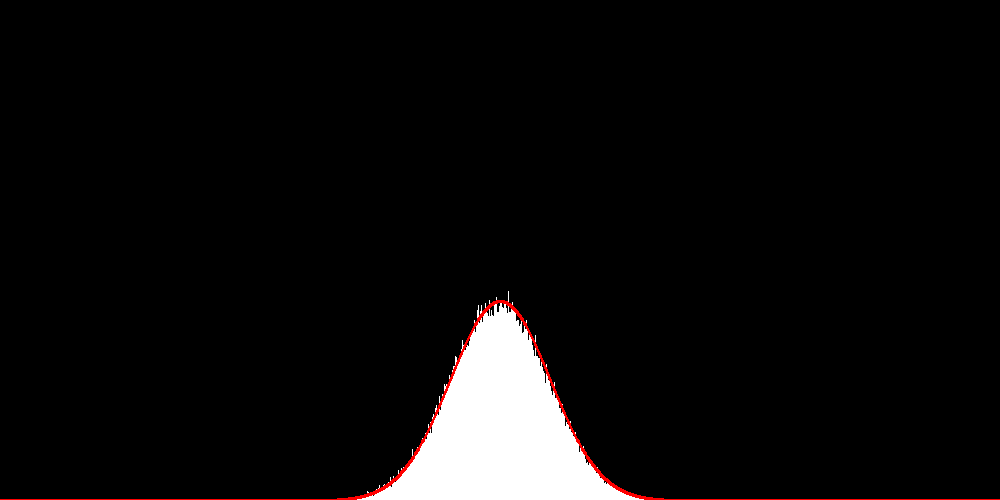

In [7]:
float mean = 0.f;
float stddev = 1.f;
int N=100000;
mkl_normal_distribution(mean, stddev, N);

std::normal_distribution: 0.0293416
stdcpp


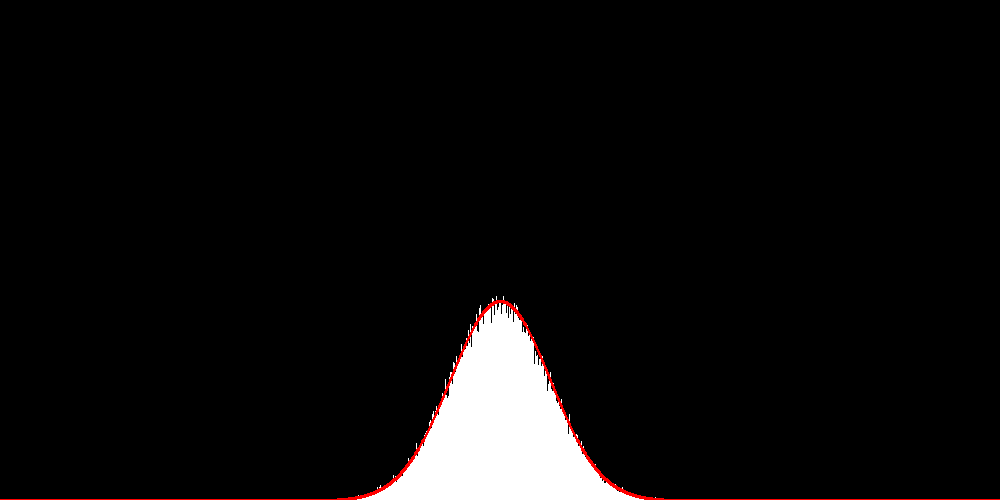

In [8]:
stdcpp_normal_distribution(mean, stddev, N);